In [141]:
# IMPORTS

import numpy as np
from glob import glob
import noisereduce as nr
import random
import librosa.display
import IPython
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as k
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import butter, lfilter, freqz,  filtfilt

In [2]:
# DIRECTORY CONTAINING PREPROCESSED KICK SPECTROGRAMS
data_dir = '/Volumes/CE_CADDY/TRAINING_SAMPLES/HIHATS_385_Prepocessed_0.3s'

In [150]:
# FUNCTIONS

## LOAD DATA
def load_data(path):
    X = []
    
    audiofiles = glob(data_dir + '/*.wav.npy')
    
    for file in audiofiles:
        
        X.append(np.load(file))
        
        
    return np.array(X)

## REMOVE NANS FROM DATA
def remove_nans(data):
    if np.isnan(data).sum() > 0:
        a = data.shape[1]
        b = data.shape[2]
        good_data_total = int(data.shape[0] - (np.isnan(data).sum() / (a * b)))
        data = data[~np.isnan(data)]
        data = data.reshape(good_data_total, a,b)
        return data
    return data

######
#HIGHPASS FILTERING

order = 4
cutoff = 5000 #Hz

def butter_highpass(cutoff, sr, order=5):
    nyq = 0.5 * sr
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, sr, order):
    b, a = butter_highpass(cutoff, sr, order=order)
    y = filtfilt(b, a, data)
    return y

######

## POST-PROCESS AND PLAY GENERATED SPECTROGRAMS
def postproc_and_play_hihat(generated_spectrogram):
    #sample rate
    sr = 48000
    # random value to pitch down sample
    pdown = random.uniform(50, 90) #50, 80
    # spectrogram back to audio
    new_hihat = librosa.griffinlim(generated_spectrogram, n_iter=128, hop_length=200)
    # noise reduction on audio
    new_hihat_nr = nr.reduce_noise(y=new_hihat, sr=sr, stationary=True, prop_decrease = 1.0, freq_mask_smooth_hz = 400)
    # pitch down audio by random amount
    new_hihat_final = librosa.effects.pitch_shift(new_hihat_nr, sr=sr, n_steps = pdown, bins_per_octave=16, res_type='kaiser_best')
    # hipass
    new_hihat_final = butter_highpass_filter(new_hihat_final, cutoff, sr, order)
    
    # display waveform and return player for audio file
    librosa.display.waveshow(new_hihat_final,sr=sr)
    return IPython.display.Audio(new_hihat_final, rate=sr)

In [4]:
# LOAD DATA
data = load_data(data_dir)

In [5]:
# CHECK DATA SHAPE BEFORE REMOVING NANS
data.shape

(384, 256, 57)

In [6]:
# CHECK NANS IN DATA
np.isnan(data).sum()

0

In [7]:
# REMOVE NANS
data = remove_nans(data)

In [8]:
# CREATE TRAINING AND VALIDATION SETS
X_train = data[:280, :, :]
X_valid = data[280:384, :, :]

Sampling layer which is called later in the function, takes in mean and log_var and randomly samples the coding from normal distribution.

In [9]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return k.random_normal(tf.shape(log_var)) * k.exp(log_var/2) + mean

In [10]:
codings_size = 10

In [11]:
w = data.shape[1]
h = data.shape[2]

In [12]:
w

256

In [13]:
h

57

encoder, mean and log_var take in same input from second layer hense not being sequential

In [14]:
inputs = layers.Input(shape=[w,h])
z = layers.Flatten()(inputs)
z = layers.Dense(300, activation='relu')(z)
z = layers.Dense(150, activation='selu')(z)
z = layers.Dense(100, activation='selu')(z)
codings_mean = layers.Dense(codings_size)(z)
codings_log_var = layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean,codings_log_var])
variational_encoder = Model(
inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

2022-12-05 13:58:14.640415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


decoder

In [15]:
decoder_inputs = layers.Input(shape=[codings_size])
x = layers.Dense(100, activation='selu')(decoder_inputs)
x = layers.Dense(150, activation='selu')(x)
x = layers.Dense(300, activation='relu')(x)
x = layers.Dense(w * h, activation='sigmoid')(x)
outputs = layers.Reshape([w, h])(x)
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

In [16]:
_,_,codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

In [17]:
latent_loss = -0.5 * k.sum(
1 + codings_log_var - k.exp(codings_log_var) - k.square(codings_mean),
axis=-1)
variational_ae.add_loss(k.mean(latent_loss)/w*h)
variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [18]:
# variational_ae.summary()

In [44]:
# SOME VARIABLES FOR GENERATION
hop_length = 300
win_length = 1200
sr = 48000
s_devs = 2

In [20]:
es = EarlyStopping(patience=20,restore_best_weights=True)

history = variational_ae.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=[X_valid, X_valid], callbacks=[es])

Epoch 1/100
9/9 [==============================] - 3s 149ms/step - loss: 784615.3125 - val_loss: 25.3292
Epoch 2/100
9/9 [==============================] - 1s 116ms/step - loss: 10.7919 - val_loss: 8.1046
Epoch 3/100
9/9 [==============================] - 1s 117ms/step - loss: 5.7680 - val_loss: 6.9161
Epoch 4/100
9/9 [==============================] - 1s 117ms/step - loss: 4.9081 - val_loss: 5.2282
Epoch 5/100
9/9 [==============================] - 1s 117ms/step - loss: 4.3094 - val_loss: 4.9369
Epoch 6/100
9/9 [==============================] - 1s 115ms/step - loss: 3.9274 - val_loss: 3.5357
Epoch 7/100
9/9 [==============================] - 1s 119ms/step - loss: 3.2619 - val_loss: 2.7556
Epoch 8/100
9/9 [==============================] - 1s 114ms/step - loss: 4.4078 - val_loss: 2.8301
Epoch 9/100
9/9 [==============================] - 1s 122ms/step - loss: 2.4327 - val_loss: 2.1069
Epoch 10/100
9/9 [==============================] - 1s 114ms/step - loss: 2.8665 - val_loss: 4.3803
Ep

Epoch 83/100
9/9 [==============================] - 1s 110ms/step - loss: 0.3333 - val_loss: 0.2784
Epoch 84/100
9/9 [==============================] - 1s 112ms/step - loss: 0.3333 - val_loss: 0.2805
Epoch 85/100
9/9 [==============================] - 1s 111ms/step - loss: 0.3340 - val_loss: 0.2804
Epoch 86/100
9/9 [==============================] - 1s 111ms/step - loss: 0.3342 - val_loss: 0.2802
Epoch 87/100
9/9 [==============================] - 1s 111ms/step - loss: 0.3342 - val_loss: 0.2794
Epoch 88/100
9/9 [==============================] - 1s 111ms/step - loss: 0.3338 - val_loss: 0.2799
Epoch 89/100
9/9 [==============================] - 1s 112ms/step - loss: 0.3340 - val_loss: 0.2817
Epoch 90/100
9/9 [==============================] - 1s 112ms/step - loss: 0.3328 - val_loss: 0.2811
Epoch 91/100
9/9 [==============================] - 1s 111ms/step - loss: 0.3349 - val_loss: 0.2801
Epoch 92/100
9/9 [==============================] - 1s 113ms/step - loss: 0.3347 - val_loss: 0.2790


In [151]:
# SAMPLE THE LATENT SPACE
codings = tf.random.normal(shape=[10, codings_size],stddev=s_devs)
images = variational_decoder(codings).numpy()

In [152]:
# variational_ae.summary()

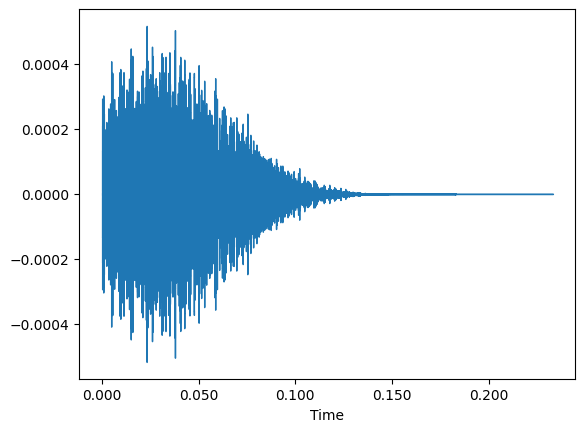

In [153]:
postproc_and_play_hihat(images[2])

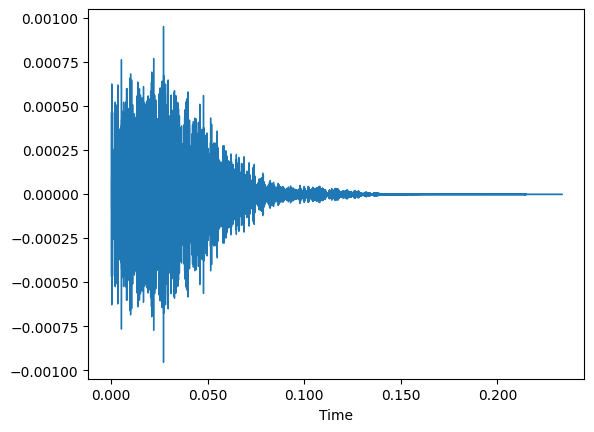

In [154]:
postproc_and_play_hihat(images[2])

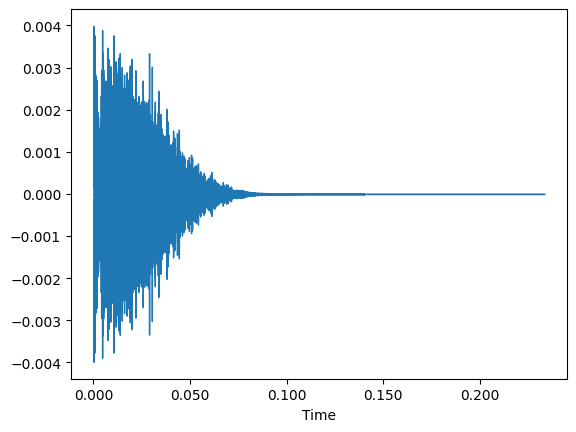

In [155]:
postproc_and_play_hihat(images[3])

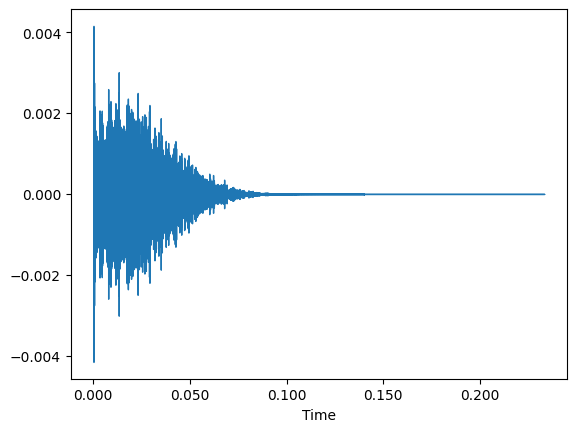

In [156]:
postproc_and_play_hihat(images[4])

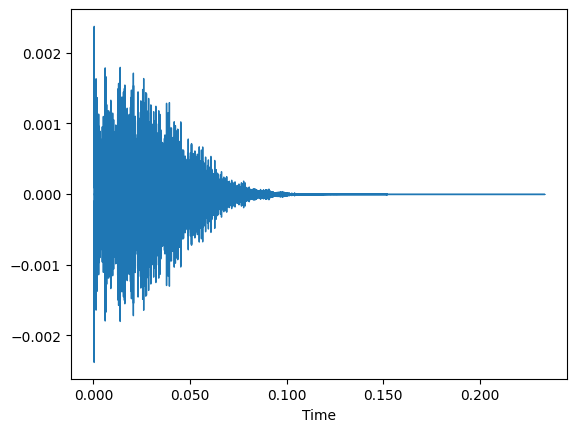

In [157]:
postproc_and_play_hihat(images[9])